# Link Prediction in Condmat

In [40]:
from datetime import datetime
import itertools
import math
from typing import List, Any, Dict, Tuple

import joblib
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV, train_test_split
import seaborn as sns
from tqdm import tqdm
from xgboost import XGBClassifier

# Typing
Author = int
Papers = List[Tuple[List[Author], datetime]]
NodePair = Tuple[Author, Author]
Edge = List[Tuple[Author, Author, Dict[str, datetime]]]

folder = '/local/bruingjde/complexnetworks2020-experiment/temp/a4n/'

In [24]:
def _get_papers(filepath: str = "src/cond-mat.hg2") -> Papers:
  """Read collaboration data in filepath and return all papers."""
  
  papers = list()
  # Get number of rows to read for the vertices.
  with open(filepath) as file:
    no_rows = int(file.readline().split(' ')[1])
 
  with open(filepath) as file:
    for paper in file.readlines()[no_rows+2:]:
      # Each line has the following format: epoch no_authors [ u v (w ...) ]
      epoch = datetime.fromtimestamp(int(paper.split(' ')[0]))
          
      no_authors = int(paper.split(' ')[1])
      index1 = paper.find('[')+2
      index2 = paper.find(']')-1

      authors = [int(auth) for auth in paper[index1:index2].split(' ')]
      assert no_authors == len(authors)
      
      papers.append((authors, epoch))
  return papers
def _filter_edgelist(edges: List[Edge], start, stop) -> List[Edge]: 
  """Filter edgelist.  If start/ stop is float, start/stop from the fraction of total edges. If datetime, this is used.""" 
  no_edges = len(edges)
  if start is None: start=0
  if stop is None: stop=1
  if type(start) is float or start == 0:
    start_index = int(start*no_edges)
    start = edges[start_index][2]['date']
  if type(stop) is float or stop == 1:
    stop_index = math.floor(stop*no_edges)-1
    stop = edges[stop_index][2]['date']
  return [edge for edge in edges if edge[2]['date'] >= start and edge[2]['date'] <= stop]
def get_edgelist(*, start=None, stop=None) -> List[Edge]:
  """Return E_[t_1, t_2]."""
  papers = _get_papers()
  edges = [
    (u, v, dict(date=date)) if u<v else (v, u, dict(date=date))
    for authors, date in papers
    for u, v in itertools.combinations(authors, 2)
  ]
  return _filter_edgelist(edges, start, stop)
def giant_component(graph: nx.Graph) -> nx.Graph: return graph.subgraph(max(nx.connected_components(graph), key=len)).copy()
def get_graph(edgelist: List[Edge]) -> nx.Graph:
  """Add edge to graph. Contains edge attribute weight."""
  g = nx.Graph()
  
  for u, v, _ in edgelist:
    weight = g[u][v]["weight"]+1 if g.has_edge(u,v) else 1
    g.add_edge(u, v, weight=weight)
  
  return g
def report(graph:nx.Graph, probes: Tuple[Author, Author]):
  n = len(probes)
  print(f"Number of probes: {n}")
  a = sum([graph.has_edge(u, v) for u, v in probes])
  print(f"- already edge: {a} ({a/n:.0%})")
  non_edges = set(nx.non_edges(graph))
  ne = sum([np in non_edges for np in probes])
  print(f"- both nodes in graph: {ne} ({ne/n:.0%})")
  ng = sum([not (graph.has_node(u) and graph.has_node(v)) for u, v in probes])
  print(f"- not in graph: {ng} ({ng/n:.0%})")
def get_distances(graph: nx.Graph, cutoff: int = None) -> (List[NodePair], List[int]):
  """
  Get all non-edges using BFS. When cutoff provided, consider only node pairs with at most this distance.
  Returns:
  - nodepairs: tuple containing all nodepairs
  - distances: tuple containing all distances
  """
  return zip(
    *[
      [(u, v), distance]
      for u, (nbs_u, _) in tqdm(nx.all_pairs_dijkstra(graph, cutoff, weight=None), total=len(graph), desc="get_distances")
      for v, distance in nbs_u.items() if distance > 1 and (cutoff is None or distance <= cutoff) 
    ]
  )

## Set-up
Choose here the parameters on how you want to define the learn and assessing phase.

In [21]:
g_learn = giant_component(get_graph(get_edgelist(stop=datetime(1999, 12, 31))))
uv_assessing = {(u, v) for u, v, _ in get_edgelist(start=datetime(2000, 1, 1))}

In [22]:
report(graph=g_learn, probes=uv_assessing)

Number of probes: 20518
- already edge: 5210 (25%)
- both nodes in graph: 4031 (20%)
- not in graph: 11276 (55%)


## Export

In [ ]:
%%time
targets = joblib.load(f'{folder}all/targets.pkl')
nodepairs = joblib.load(f'{folder}all/nodepairs.pkl')
distances = joblib.load(f'{folder}all/distances.pkl')
g_learn = joblib.load(f'{folder}all/graph.pkl')

In [ ]:
nodepairs, distances = get_distances(g_learn)
targets = [nodepair in uv_assessing for nodepair in tqdm(nodepairs)]

In [6]:
nodepairs = np.array(nodepairs)
distances = np.array(distances)
targets = np.array(targets)

In [20]:
for select_distance in [2, 3, 4]:
  print(select_distance)
  filter_indices = (distances == select_distance)
  nodepairs[filter_indices].dump(f'{folder}{select_distance}/nodepairs.pkl')
  distances[filter_indices].dump(f'{folder}{select_distance}/distances.pkl')
  targets[filter_indices].dump(f'{folder}{select_distance}/targets.pkl')
  joblib.dump(g_learn, f'{folder}{select_distance}/graph.pkl')

2
3
4


In [18]:
print(f'{sum(targets) / len(nodepairs):e}')

2.935012e-05


## Distance analysis

In [26]:
df = pd.DataFrame(dict(distances=distances, targets=targets))
df = df.groupby('distances')['targets'].agg(['size', 'sum'])

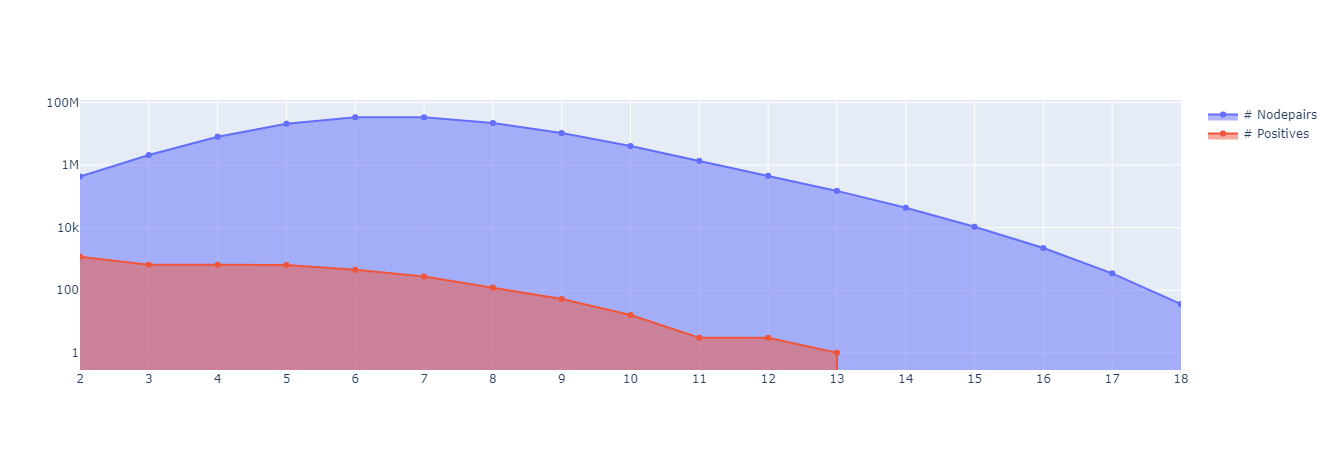

In [27]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index, y=df['size'], fill='tozeroy', name='# Nodepairs'))
fig.add_trace(go.Scatter(x=df.index, y=df['sum'], fill='tozeroy', name='# Positives'))
fig.update_layout(xaxis=dict(tickmode='linear', tick0=2, dtick=1), yaxis_type="log")
fig.show()

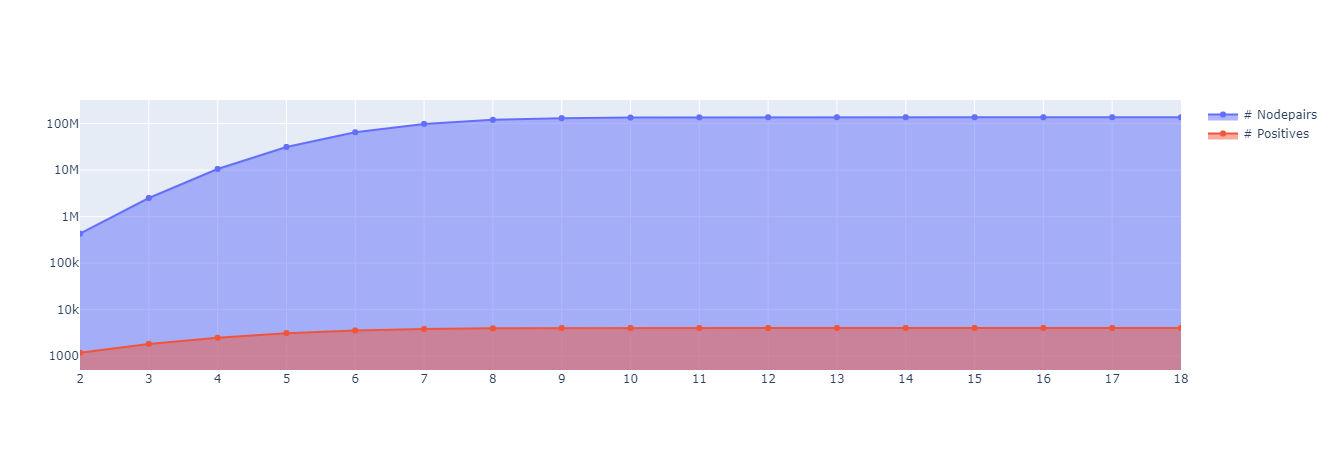

In [28]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index, y=df['size'].cumsum(), fill='tozeroy', name='# Nodepairs'))
fig.add_trace(go.Scatter(x=df.index, y=df['sum'].cumsum(), fill='tozeroy', name='# Positives'))
fig.update_layout(xaxis=dict(tickmode='linear', tick0=2, dtick=1), yaxis_type="log")

## Feature inspection

In [ ]:
%%time
df = joblib.load("temp/a4n/2/features.pkl")

In [ ]:
fig = px.imshow(df.corr(), x=df.columns, y=df.columns)
fig.update_xaxes(side="top")

In [ ]:
def pairplot(df):
  return sns.pairplot(
    df[df['target']].append(df[~df['target']].sample(sum(df['target']))).apply(minmax_scale), 
    hue='target',
    hue_order=[True, False],
    palette={True: 'green', False: 'red'},
    kind='reg',
    diag_kws=dict(bw=.02),
    plot_kws=dict(scatter_kws=dict(alpha=.1))
  )

In [ ]:
pairplot(df)

## Hyperparameter selection

See `parameter_optimalization.ipynb`. We choose the following parameters:
- `max_depth = 1`
- `tree_method = 'hist'`
- `no feature scaling`

### XGBoost

$n=2$

In [66]:
def gridsearch(df: pd.DataFrame, random_state=1) -> pd.DataFrame:
  X = df.drop(columns='target').values
  y = df['target'].values
  
  param_grid=dict(max_depth=[1, 2], scale_pos_weight=[sum(~y)/sum(y), 1])
  
  X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=1/3, random_state=random_state)
  clf = XGBClassifier(random_state=random_state, tree_method='hist', n_jobs=6)
  gridsearch = GridSearchCV(
    clf, 
    param_grid=param_grid, 
    scoring='average_precision', 
    n_jobs=30,
    cv=StratifiedKFold(shuffle=True, random_state=random_state),
    return_train_score=True
  )
  gridsearch.fit(X_trainval, y_trainval)
  df = pd.DataFrame(
    dict(train=gridsearch.cv_results_['mean_train_score'], test=gridsearch.cv_results_['mean_test_score']), 
    index=pd.Index([(d['max_depth'], d['scale_pos_weight'] > 1) for d in gridsearch.cv_results_['params']], name=('max_depth', 'balanced'))
  )
  df['diff'] = (df['test'] - df['train']).abs()
  return df.sort_values('test', ascending=False)
def report_performance(df: pd.DataFrame, random_state=1, max_depth=1, tree_method='hist', balanced=True, n_jobs=128):
  X = df.drop(columns='target').values
  y = df['target'].values
  X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=1/3, random_state=random_state)
  clf = XGBClassifier(max_depth=max_depth, n_jobs=128, tree_method=tree_method, scale_pos_weight=sum(~y)/sum(y) if balanced else 1 , random_state=random_state)
  clf.fit(X_trainval, y_trainval)
  y_pred = clf.predict_proba(X_test)[:,1]
  return average_precision_score(y_test, y_pred), roc_auc_score(y_test, y_pred)

In [61]:
gridsearch(pd.read_pickle(f'temp/a1/2/features.pkl'))

,,train,test,diff
max_depth,balanced,,,
2,False,0.028567,0.011711,0.016857
1,False,0.012720,0.011336,0.001385
2,True,0.020108,0.010128,0.009979
1,True,0.010845,0.009457,0.001388


In [63]:
gridsearch(pd.read_pickle(f'temp/a1/3/features.pkl'))

,,train,test,diff
max_depth,balanced,,,
2,False,0.012686,0.002443,0.010243
1,True,0.002354,0.002340,0.000014
2,True,0.004258,0.002081,0.002177
1,False,0.002263,0.001982,0.000281


In [69]:
gridsearch(pd.read_pickle(f'temp/a1/4/features.pkl'))

train      test      diff
max_depth balanced                              
2         False     0.003662  0.001274  0.002388
1         False     0.001254  0.000816  0.000437
          True      0.000515  0.000628  0.000113
2         True      0.000819  0.000402  0.000417

In [67]:
report_performance(pd.read_pickle(f'temp/a1/2/features.pkl'), balanced=False)

(0.01161405871585572, 0.7167960845889996)

In [68]:
report_performance(pd.read_pickle(f'temp/a1/3/features.pkl'), balanced=True)

(0.0011615687309137015, 0.7464862309289879)

In [70]:
report_performance(pd.read_pickle(f'temp/a1/4/features.pkl'), balanced=True)

(0.00032047810413316836, 0.709864007885863)